##  simple self-attention mechanism without trainable weights
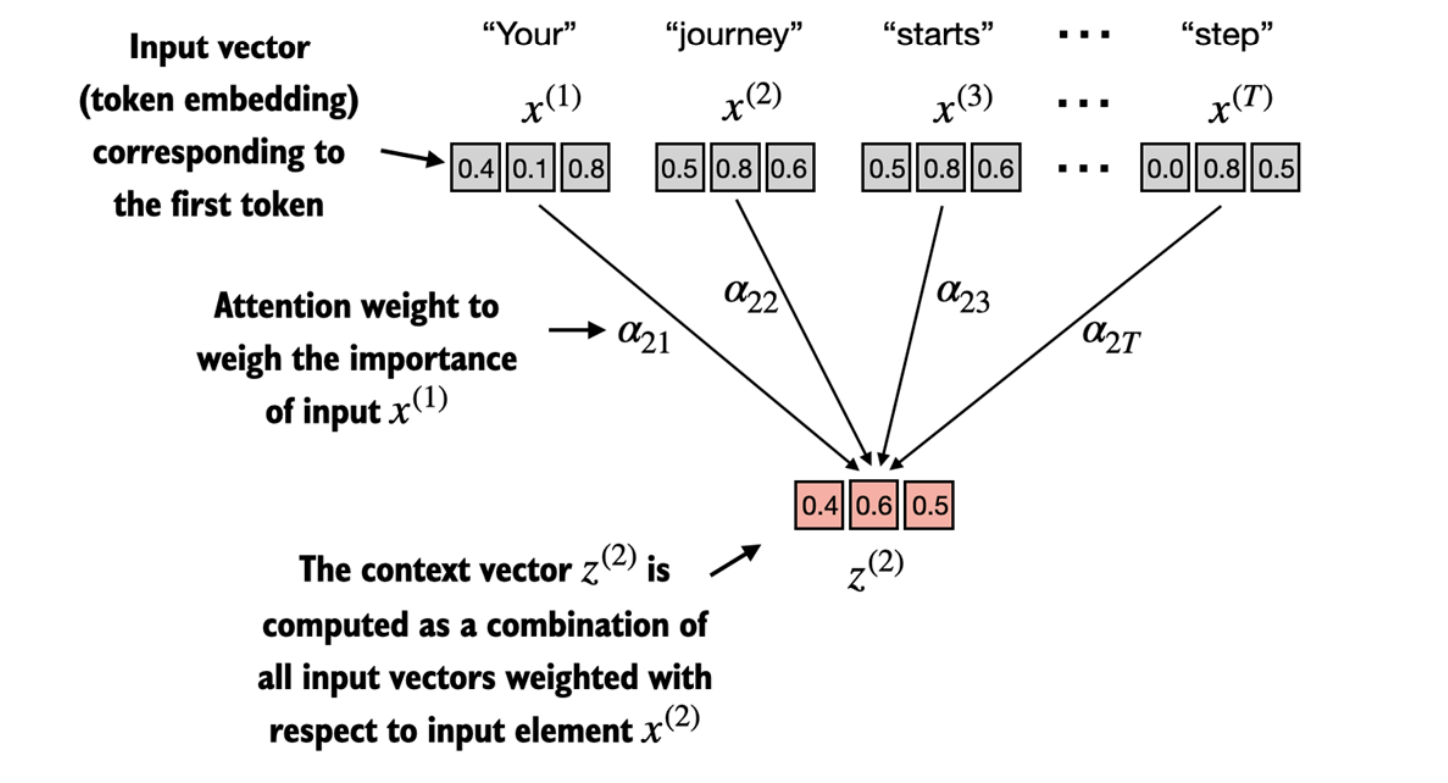
The goal of **self-attention** is to compute a context vector, for each input element, that combines
information from all other input elements. In the example depicted in this figure, we compute the context
vector z^2. The importance or contribution of each input element for computing z^2 is determined by the attention weights α21 to α2T. When computing z^2, the attention weights are calculated with respect to input element x

**we implement a simplified self-attention mechanism to compute these
weights and the resulting context vector one step at a time.
Consider the following input sentence, which has already been embedded into 3-
dimensional vectors**

In [1]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
    [0.55, 0.87, 0.66], # journey (x^2)
    [0.57, 0.85, 0.64], # starts (x^3)
    [0.22, 0.58, 0.33], # with (x^4)
    [0.77, 0.25, 0.10], # one (x^5)
    [0.05, 0.80, 0.55]] # step (x^6)
)

The overall goal of this section is to illustrate the computation of the context vector z^2 using the
second input element, x^2 as a query. This figure shows the first intermediate step, computing the attention
scores ω between the query x^2 and all other input elements as a dot product. (Note that the numbers in the
figure are truncated to one digit after the decimal point to reduce visual clutter.)
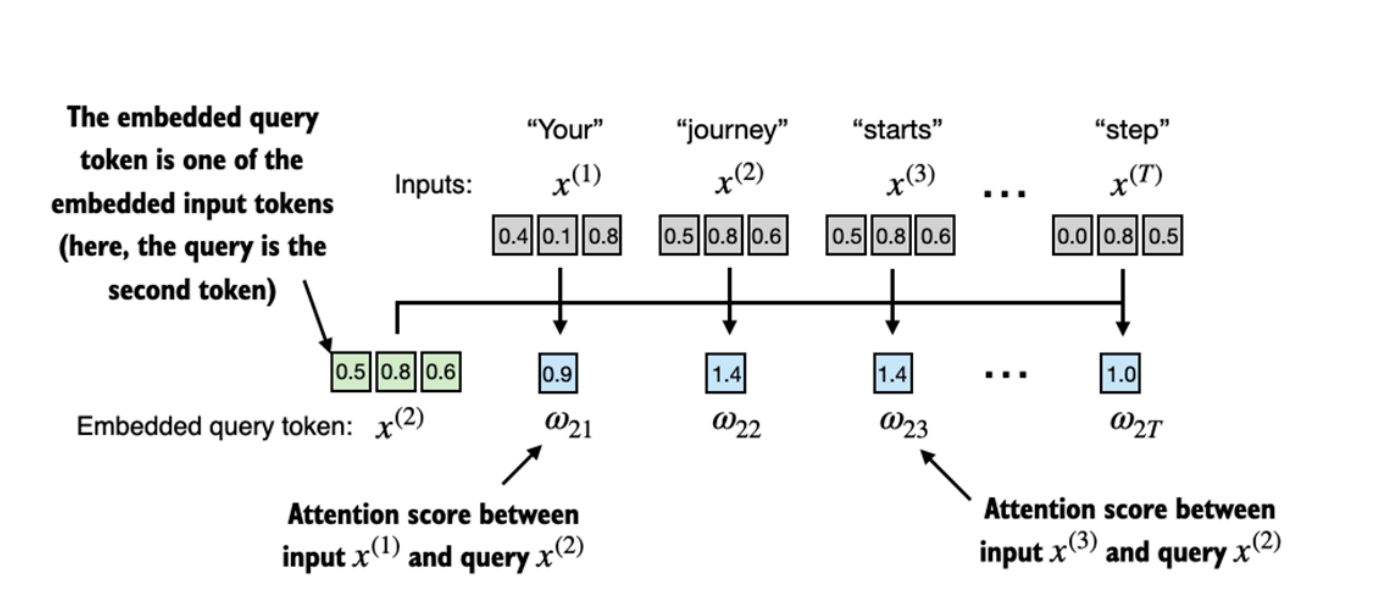

In [24]:
inputs[1] 

tensor([0.5500, 0.8700, 0.6600])

In [25]:
query = inputs[1]

In [4]:
inputs.shape

torch.Size([6, 3])

In [3]:
inputs.shape[0]

6

In [5]:
torch.empty(6)

tensor([0., 0., 0., 0., 0., 0.])

In [26]:
attn_scores_2 = torch.empty(inputs.shape[0])

In [27]:
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In the next step, we **normalize** each of the attention scores that we computed previously.
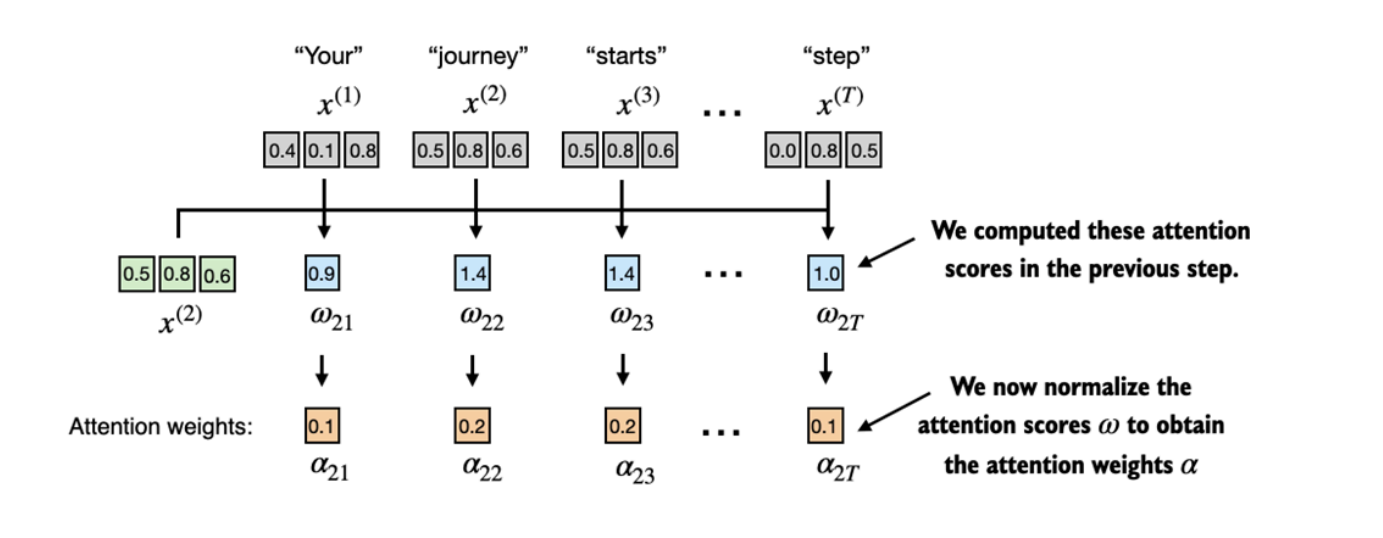
The main goal behind the normalization is to obtain attention weights that sum up to 1.

In [47]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


**softmax function** for **normalization**. This approach is better at managing extreme values and offers more favorable gradient
properties during training. Below is a basic implementation of the softmax function for normalizing the attention scores:

**softmax function** ensures that the attention weights are always positive.
This makes the output interpretable as probabilities or relative importance, where higher
weights indicate greater importance.


In [50]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)
    
attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


**softmax** function by using **pytorch**

In [51]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Now that we computed the **normalized attention** weights, we are ready for the final step illustrated, calculating the **context vector** z^2 by multiplying the embedded input tokens, x^i, with the corresponding attention weights and then summing the resulting vectors.
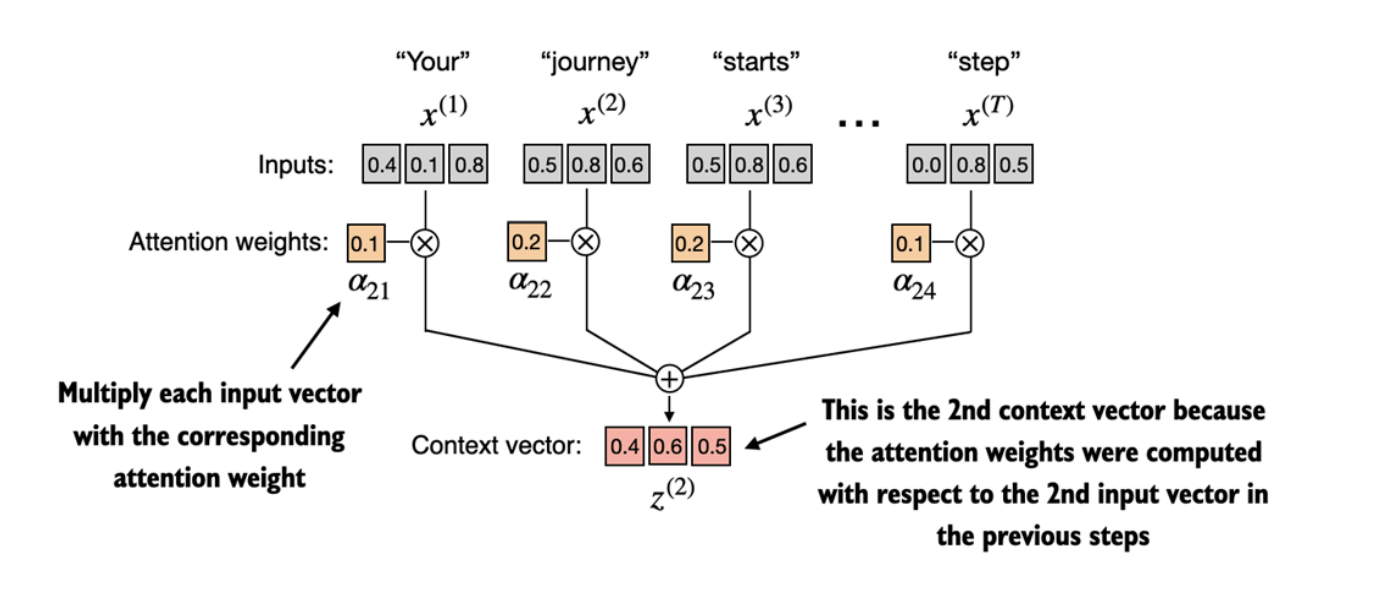
The final step, after calculating and **normalizing** the attention scores to obtain the attention weights for query x^2, is to compute the **context vector** z^2. This **context vector** is a combination of all input vectors x^1 to x^T weighted by the attention weights.

In [52]:
query = inputs[1] # 2nd input token is the query
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### Computing attention weights for all input tokens
previous, we computed attention weights and the context vector for input 2. Now, we are extending this computation to calculate attention weights and context vectors for all inputs.
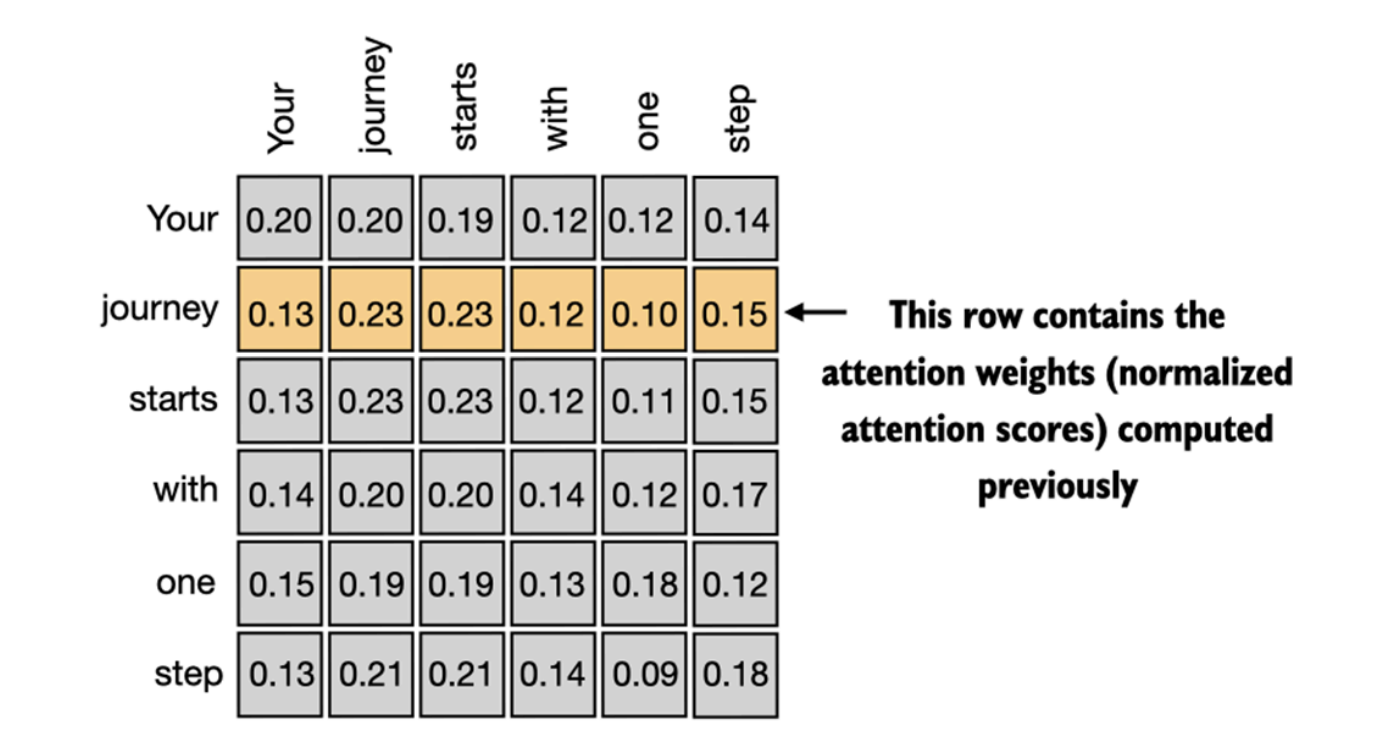

We follow the same three steps as before, except that we make a few modifications in the code to compute all context vectors instead of only the second context vector, z^2.
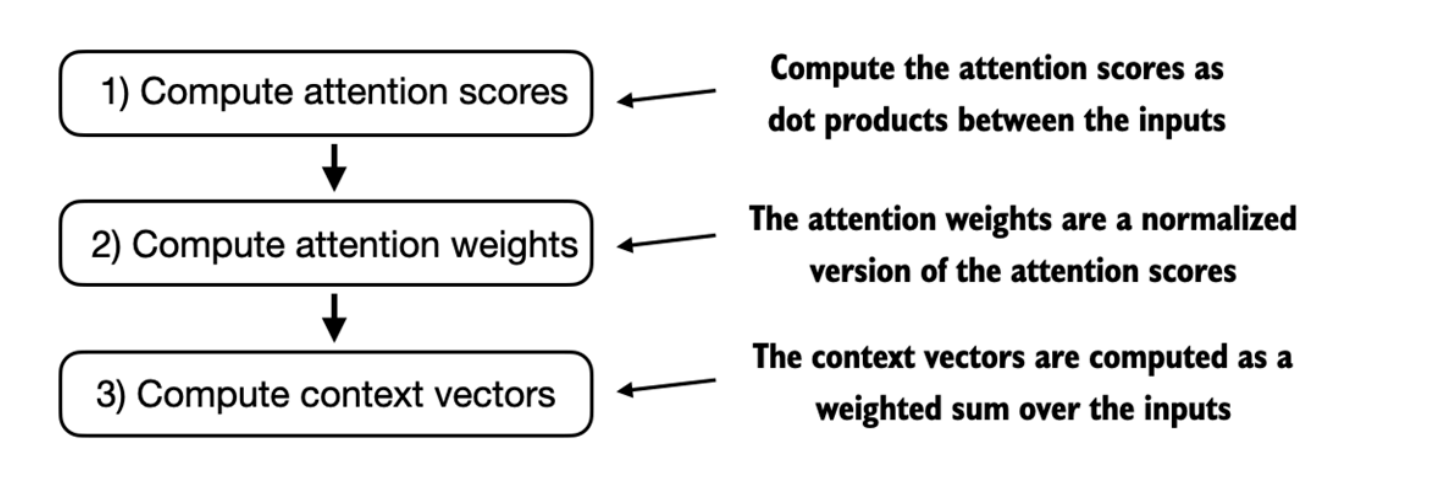
In **self-attention**, we begin by computing the attention scores, which are then normalized to obtain attention weights that sum up to 1. These attention weights are used to compute the context vectors as a weighted sum of the inputs.

In [53]:
# in step 1 as illustrated, we add an additional for-loop to compute the dot products for all pairs of inputs.
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


When computing the preceding attention score tensor, we used for-loops in Python. However, for-loops are generally slow, and we can achieve the same results using **matrix multiplication**:

In [54]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [55]:
# In step 2, we now normalize each row so that the values in each row sum to 1:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


Before we move on to step 3, let's briefly verify that the rows indeed all sum to 1:

In [56]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [57]:
# In the third and last step, we now use these attention weights to compute all context vectors via matrix multiplication:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
